In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from backtest_functions_v1b import *

### strategy baseline: take simple mean of all 6 absa column

In [2]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


In [3]:
df.describe()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
count,1461.000000,1438.000000,1421.000000,1425.000000,1427.000000,1438.000000,1202.000000,1461.000000
mean,106.341547,0.204244,-0.067238,-0.012217,0.478250,0.510591,-0.417578,0.001323
std,56.654991,0.298990,0.253940,0.306260,0.199329,0.158141,0.388851,0.032388
min,18.000000,-0.760000,-0.850000,-1.000000,-0.550000,-0.166667,-1.000000,-0.159747
25%,65.000000,0.004545,-0.250000,-0.225000,0.377350,0.427068,-0.700000,-0.013760
50%,98.000000,0.229615,-0.077778,0.000000,0.500000,0.534783,-0.500000,-0.000007
75%,132.000000,0.436364,0.111765,0.217857,0.612500,0.620000,-0.213542,0.016019
max,378.000000,0.868421,0.700000,0.800000,1.000000,1.000000,1.000000,0.187465


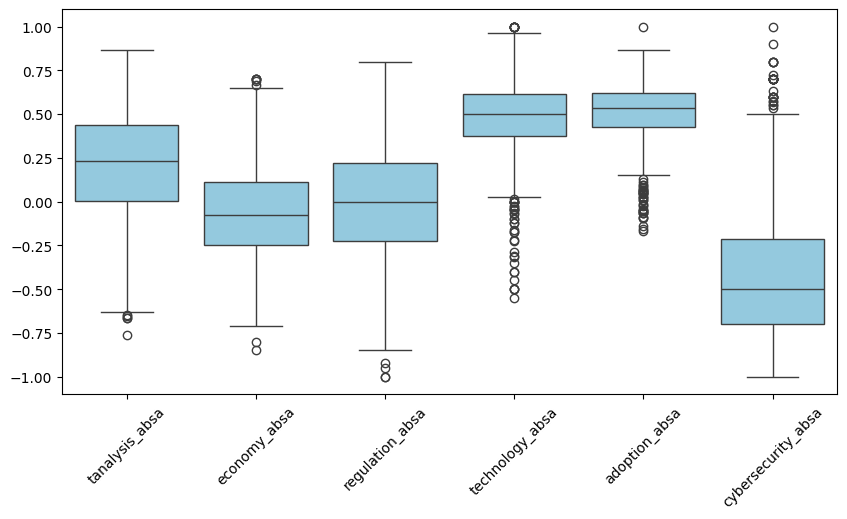

In [4]:
# plot the distribution of the columns
columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[columns], color='skyblue')
plt.xticks(rotation=45)
plt.show()

In [5]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count'], inplace=True)
df.head()

,return_forward_1d,signal
2021-01-01,0.093726,0.223380
2021-01-02,0.020380,0.325500
2021-01-03,-0.024712,0.408182
2021-01-04,0.063197,0.224037
2021-01-05,0.083311,0.565286


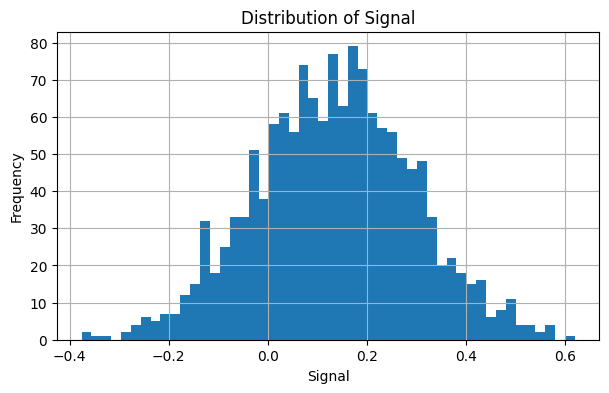

In [6]:
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Signal smoothing
df['signal'] = df['signal'].ewm(span=3).mean()
# df['signal'] = df['signal'].rolling(window=3).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

Overall Annual Return: 45.66%
Overall Annual Sharpe Ratio: 2.4135
Maximum Drawdown: -7.66 %
Win/Loss Ratio: 1.25
Alpha: 0.2211
Beta: 0.2619

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.456629    0.189197     0.261902       0.22113       2.413507


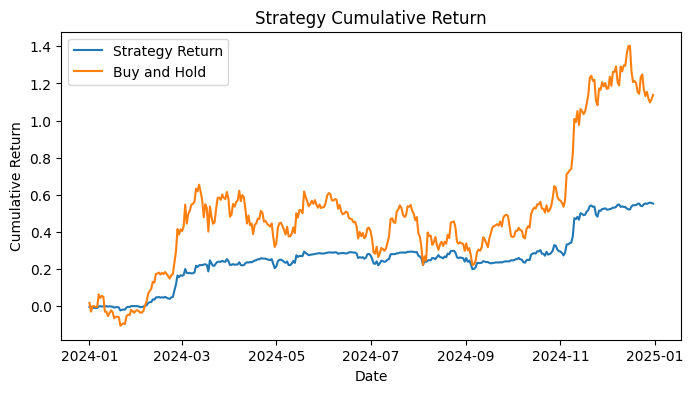

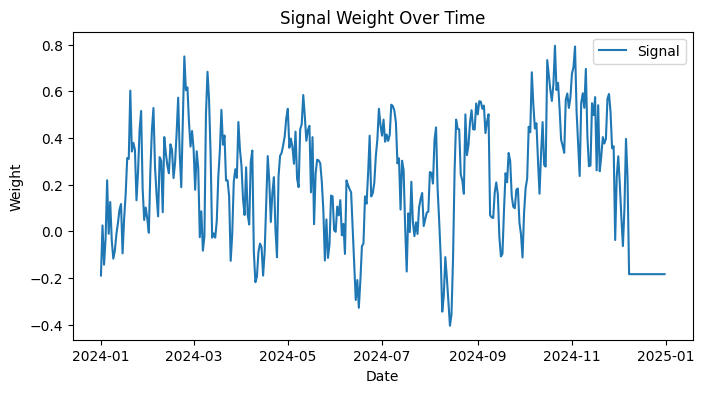

In [8]:
# backtest 2024 only
df = df[df.index.year == 2024]

run_backtest(df)

Overall Annual Return: 91.33%
Overall Annual Sharpe Ratio: 2.4135
Maximum Drawdown: -14.9 %
Win/Loss Ratio: 1.25
Alpha: 0.4423
Beta: 0.5238

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.913258    0.378394     0.523803      0.442259       2.413507


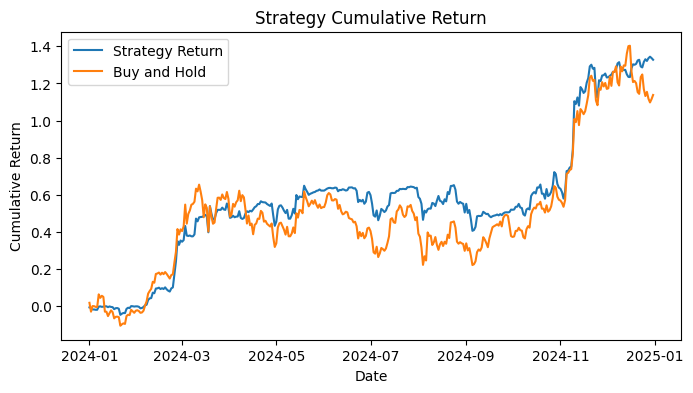

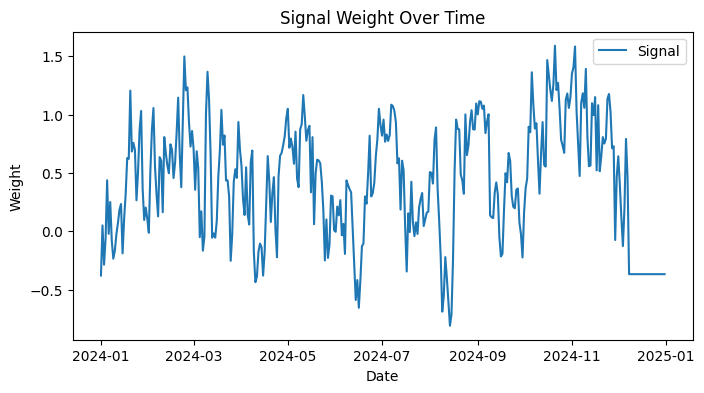

In [9]:
# backtest 2024 only
df = df[df.index.year == 2024]

df['signal'] = df['signal'] * 2

run_backtest(df)

### investigate each feature

In [10]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


In [11]:
df.columns

Index(['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa',
       'return_forward_1d'],
      dtype='object')

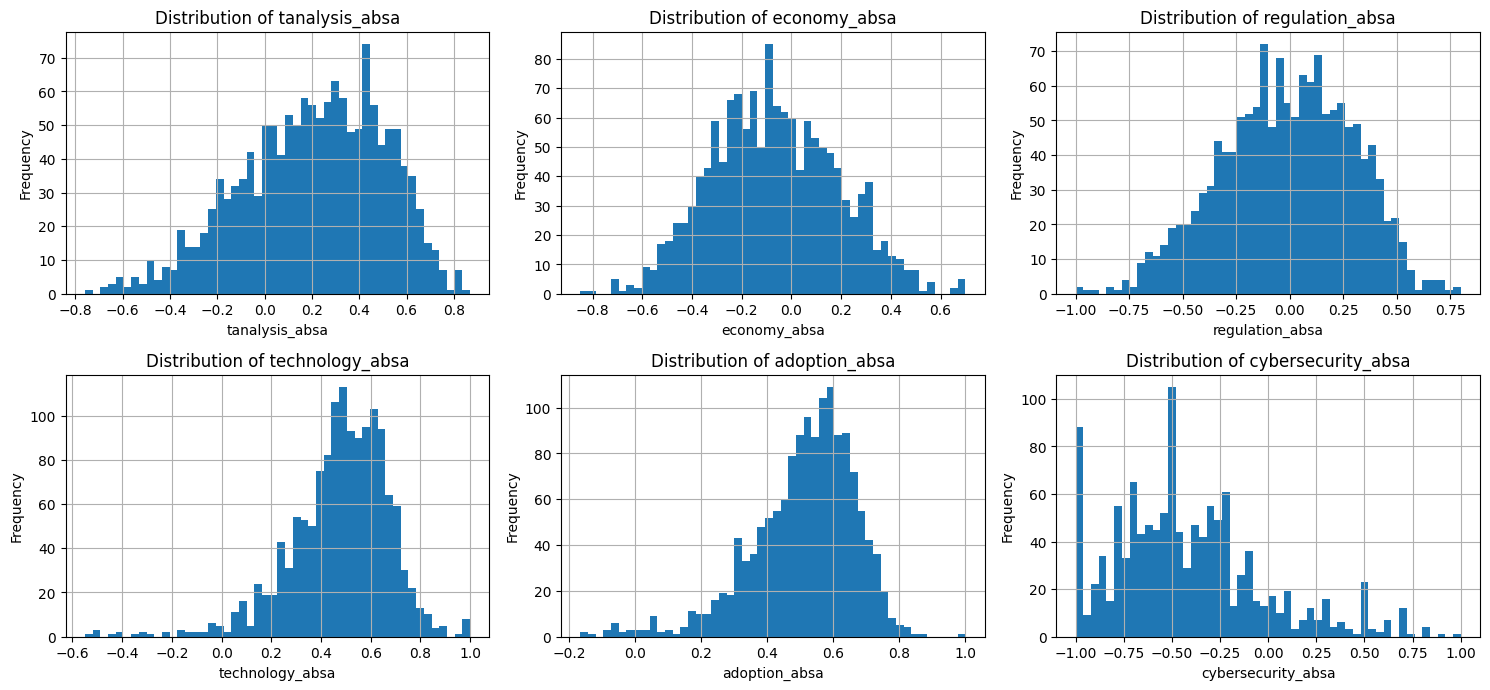

In [12]:
# plot the distribution of the columns
# columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa',
#        'technology_absa', 'adoption_absa', 'cybersecurity_absa', 'return_forward_1d']

columns = ['tanalysis_absa', 'economy_absa', 'regulation_absa',
       'technology_absa', 'adoption_absa', 'cybersecurity_absa']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
  df[column].hist(ax=axes[i], bins=50)
  axes[i].set_title(f'Distribution of {column}')
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frequency')

# Remove empty subplots
for j in range(len(columns), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

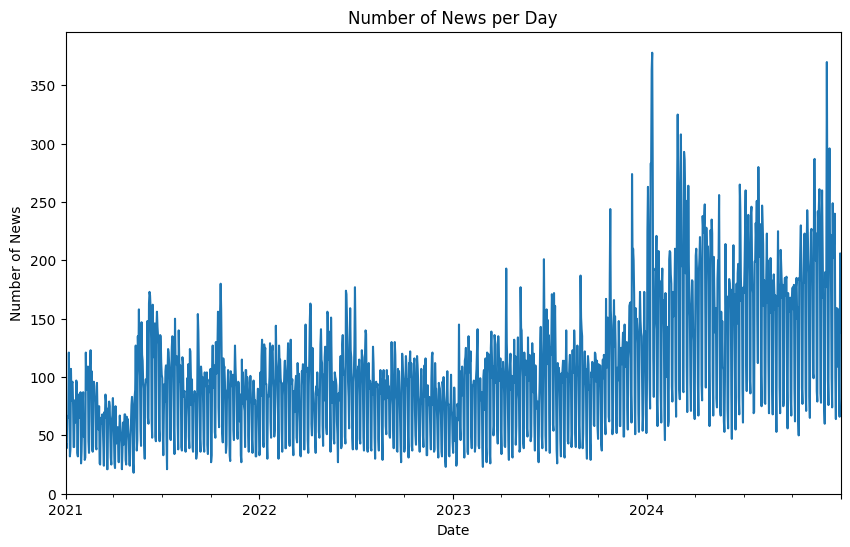

In [13]:
df['news_count'].plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of News')
plt.title('Number of News per Day')
plt.show()

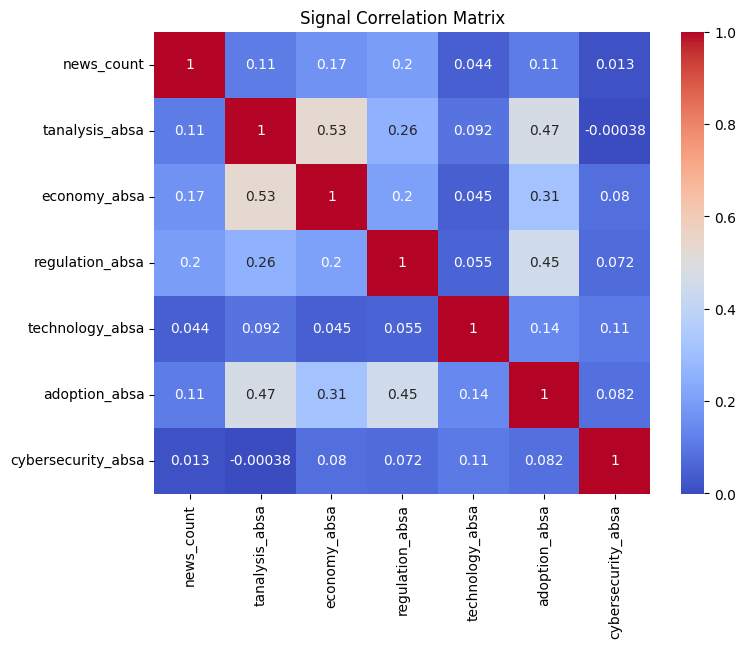

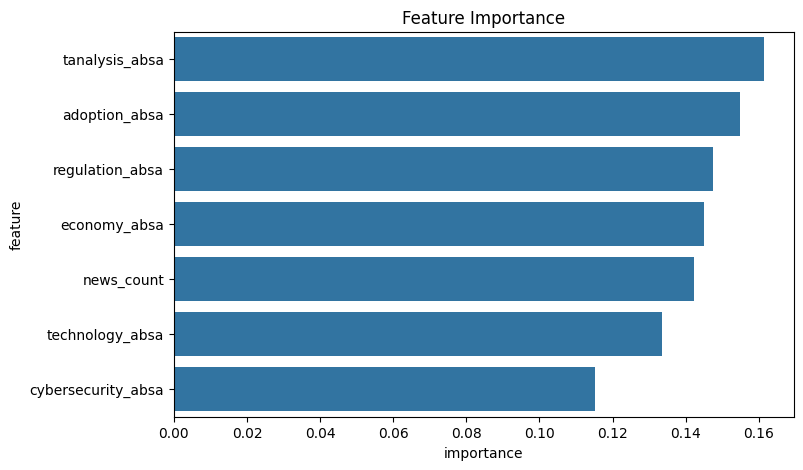


Statistical Analysis:
              feature    f_score       p_value
1      tanalysis_absa  32.140325  1.726121e-08
5       adoption_absa  18.622930  1.700162e-05
2        economy_absa   8.499293  3.607082e-03
4     technology_absa   5.372281  2.059695e-02
3     regulation_absa   2.344793  1.259190e-01
6  cybersecurity_absa   1.386492  2.391904e-01
0          news_count   0.058373  8.091209e-01


In [14]:
def analyze_features(df, signal_columns):
  # 1. Correlation Analysis
  correlation_matrix = df[signal_columns].corr()
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.title('Signal Correlation Matrix')
  plt.show()
  
  # 2. Feature Importance using Random Forest
  X = df[signal_columns].fillna(method='ffill').fillna(method='bfill') # Forward fill then backward fill
  y = df['return_forward_1d']
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X, y)
  
  importance_df = pd.DataFrame({
      'feature': signal_columns,
      'importance': rf.feature_importances_
  }).sort_values('importance', ascending=False)
  
  plt.figure(figsize=(8, 5))
  sns.barplot(data=importance_df, x='importance', y='feature')
  plt.title('Feature Importance')
  plt.show()
  
  # 3. Statistical Analysis
  f_scores, p_values = f_regression(X, y)
  stats_df = pd.DataFrame({
    'feature': signal_columns,
    'f_score': f_scores,
    'p_value': p_values
  }).sort_values('f_score', ascending=False)
  
  print("\nStatistical Analysis:")
  print(stats_df)
  
  return correlation_matrix, importance_df, stats_df

signal_columns = ['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
corr_matrix, importance, stats = analyze_features(df, signal_columns)

In [15]:
df = df[df.index.year == 2024]

Overall Annual Return: 47.12%
Overall Annual Sharpe Ratio: 2.0952
Maximum Drawdown: -16.85 %
Win/Loss Ratio: 1.13
Alpha: 0.3459
Beta: 0.1393

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.471246    0.224922     0.139347      0.345947       2.095156


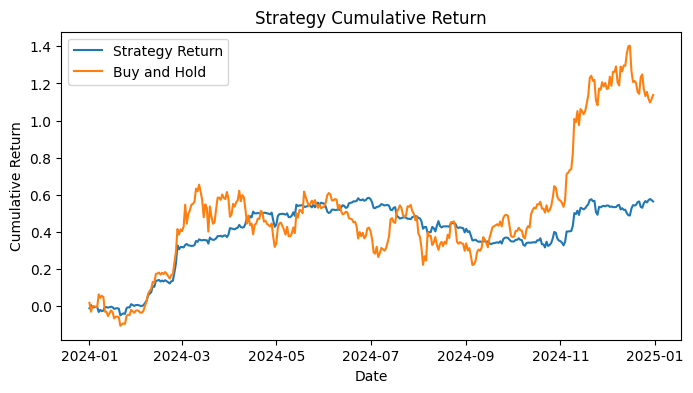

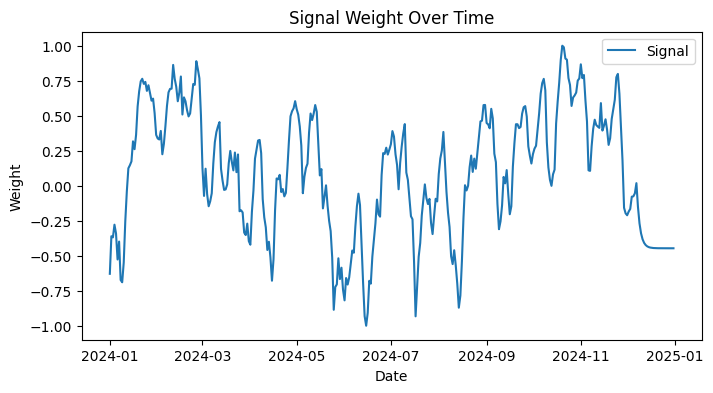

In [16]:
# backtest tanalysis_absa as signal
df['signal'] = df['tanalysis_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=4).mean() # 4 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 59.19%
Overall Annual Sharpe Ratio: 1.7777
Maximum Drawdown: -19.36 %
Win/Loss Ratio: 1.08
Alpha: 0.0699
Beta: 0.5805

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.591874    0.332935     0.580495      0.069899       1.777746


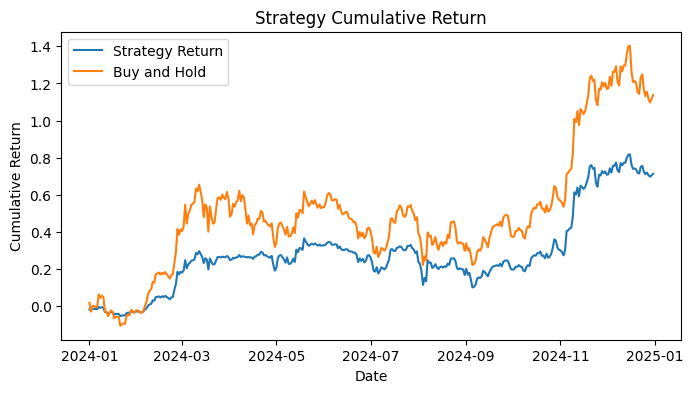

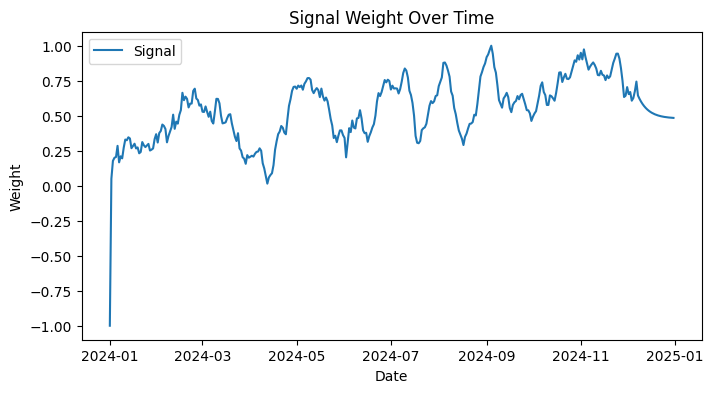

In [17]:
# backtest economy_absa as signal
df['signal'] = df['economy_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=13).mean() # 13 days ewm gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 33.53%
Overall Annual Sharpe Ratio: 1.7691
Maximum Drawdown: -10.67 %
Win/Loss Ratio: 1.01
Alpha: 0.295
Beta: 0.0448

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.335271    0.189516     0.044787      0.294999       1.769095


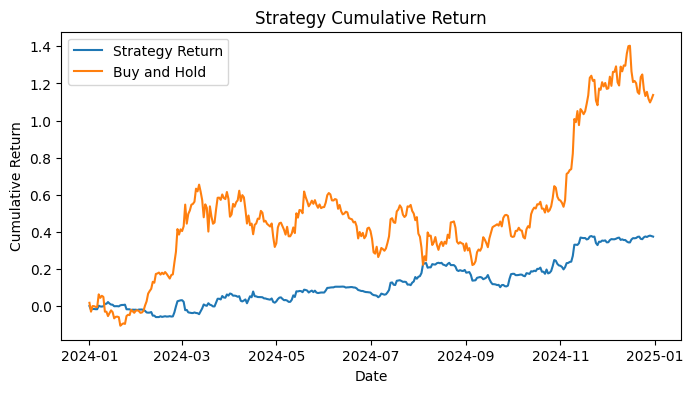

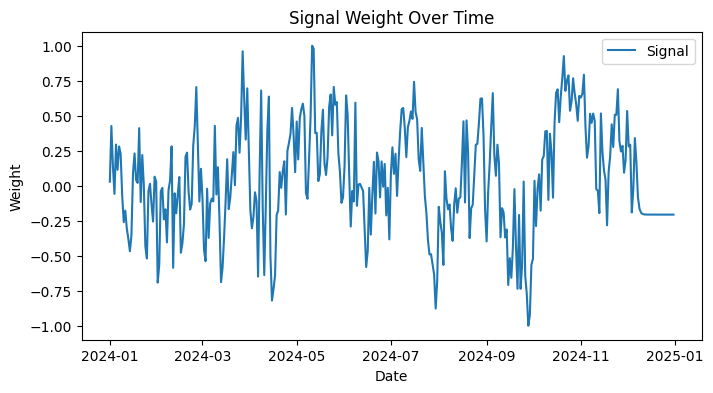

In [18]:
# backtest regulation_absa as signal
df['signal'] = df['regulation_absa']
df['signal'] = df['signal'].fillna(0)
df['signal'] = df['signal'].ewm(span=2).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 56.53%
Overall Annual Sharpe Ratio: 2.3793
Maximum Drawdown: -11.61 %
Win/Loss Ratio: 1.15
Alpha: 0.2631
Beta: 0.3361

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.565346    0.237612     0.336088      0.263139       2.379285


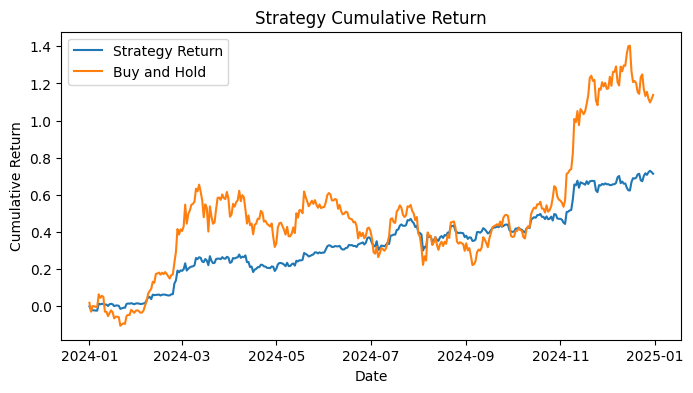

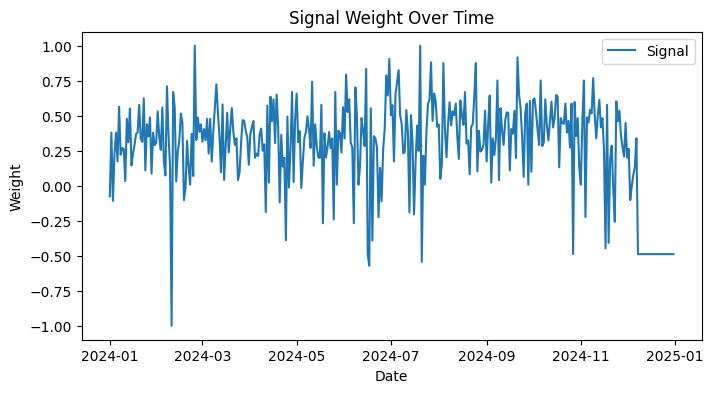

In [19]:
# backtest technology_absa as signal
df['signal'] = df['technology_absa']
df['signal'] = df['signal'].fillna(0)

# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: 67.46%
Overall Annual Sharpe Ratio: 2.1024
Maximum Drawdown: -19.19 %
Win/Loss Ratio: 1.08
Alpha: 0.2584
Beta: 0.4629

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.674614    0.320882     0.462911      0.258369       2.102375


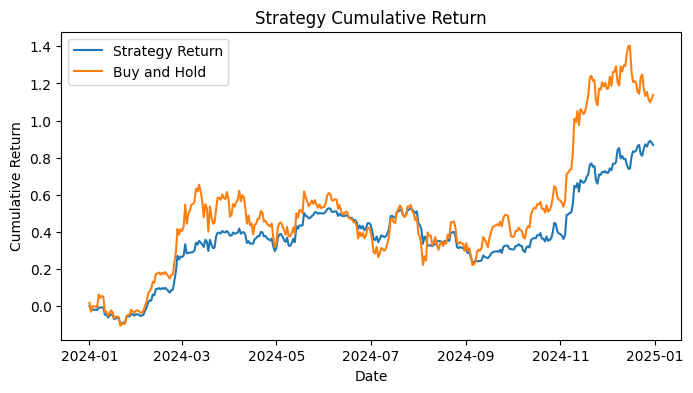

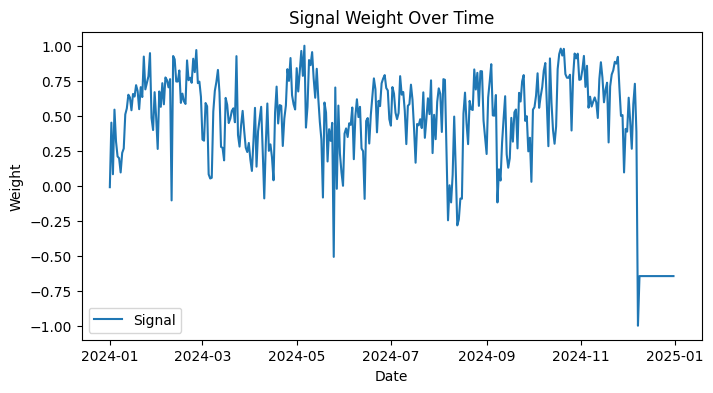

In [20]:
# backtest adoption_absa as signal
df['signal'] = df['adoption_absa']
df['signal'] = df['signal'].fillna(0)

# no smmothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

Overall Annual Return: -19.65%
Overall Annual Sharpe Ratio: -0.7802
Maximum Drawdown: -30.96 %
Win/Loss Ratio: 0.97
Alpha: -0.0252
Beta: -0.1906

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.196538    0.251914    -0.190584     -0.025166      -0.780179


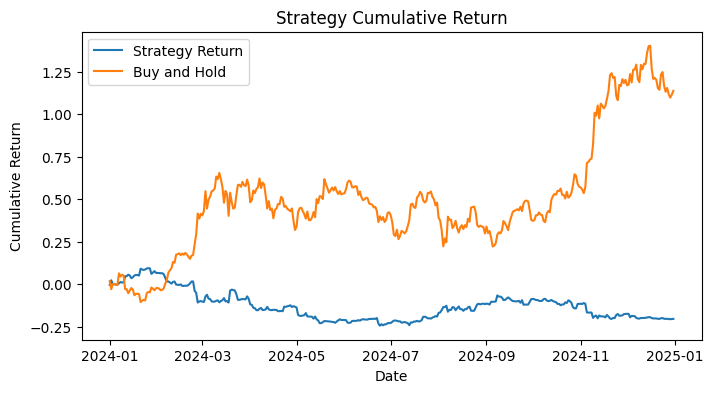

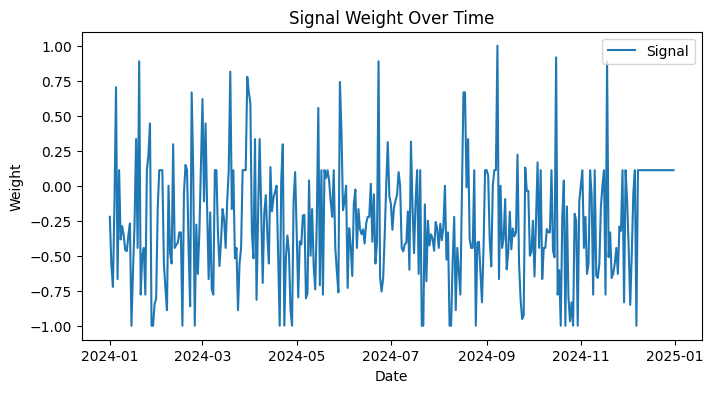

In [21]:
# backtest cybersecurity_absa as signal
df['signal'] = df['cybersecurity_absa']
df['signal'] = df['signal'].fillna(0)

# no smoothing gives the best result

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df)

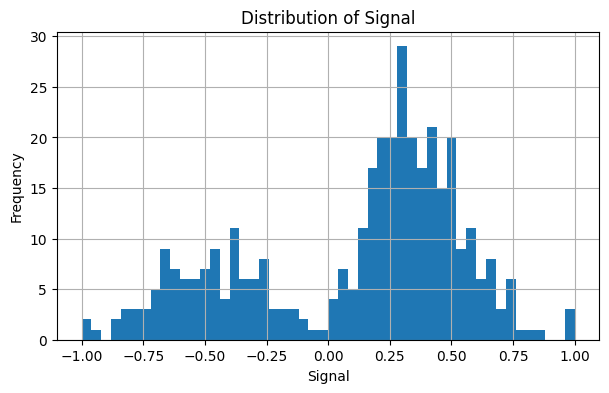

Overall Annual Return: -6.94%
Overall Annual Sharpe Ratio: -0.2621
Maximum Drawdown: -32.03 %
Win/Loss Ratio: 0.97
Alpha: -0.1922
Beta: 0.1366

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.069404    0.264758      0.13661     -0.192242      -0.262142


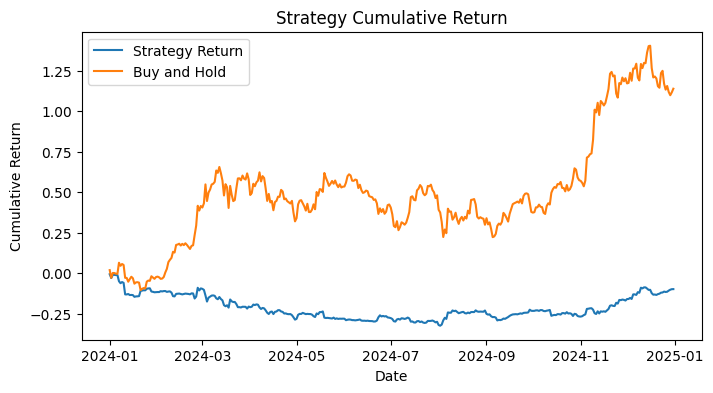

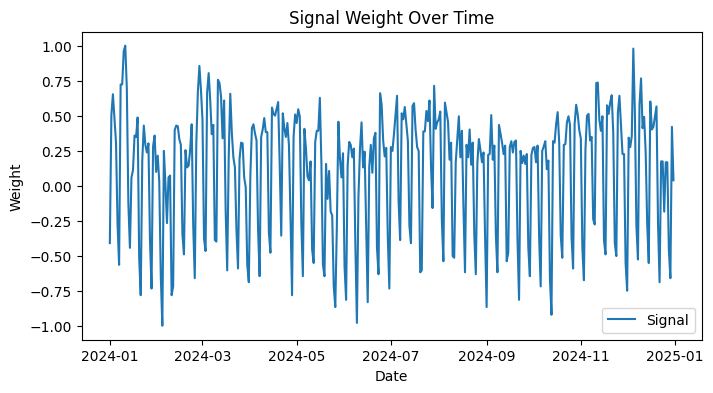

In [22]:
# backtest news_count as signal
df['signal'] = df['news_count']
df['signal'] = df['signal'].fillna(0)

# feature scaling, right skewed, log transformation
df['signal'] = np.log1p(df['signal'])

# scale the signal to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

# plot the distribution of the signal
df['signal'].hist(bins=50, figsize=(7, 4))
plt.title('Distribution of Signal')
plt.xlabel('Signal')
plt.ylabel('Frequency')
plt.show()

run_backtest(df)


### strategy: simple mean of 5 absa cols

In [23]:
df_news = pd.read_parquet('../data/5.PROD_cryptonews.parquet')
df = concat_return(df_news)
df.head()

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,return_forward_1d
2021-01-01,34,0.744828,0.450000,-0.700000,0.5,0.645455,-0.3,0.093726
2021-01-02,43,0.827500,0.500000,-0.300000,0.1,0.500000,NaN,0.020380
2021-01-03,39,0.824242,-0.100000,0.300000,0.4,0.616667,NaN,-0.024712
2021-01-04,66,0.077049,0.200000,-0.233333,0.6,0.476471,NaN,0.063197
2021-01-05,65,0.580000,0.571429,0.525000,0.5,0.650000,NaN,0.083311


In [24]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa']
df['signal'] = df[cols].mean(axis=1)
df.drop(columns=cols, inplace=True)
df.drop(columns=['news_count', 'cybersecurity_absa'], inplace=True)
df.head()

,return_forward_1d,signal
2021-01-01,0.093726,0.328056
2021-01-02,0.020380,0.325500
2021-01-03,-0.024712,0.408182
2021-01-04,0.063197,0.224037
2021-01-05,0.083311,0.565286


In [25]:
df = df.fillna(0)

# apply ewm
df['signal'] = df['signal'].ewm(span=4).mean()

# feature transformation
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

Overall Annual Return: 58.5%
Overall Annual Sharpe Ratio: 2.4338
Maximum Drawdown: -12.26 %
Win/Loss Ratio: 1.19
Alpha: 0.291
Beta: 0.327

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        0.58502    0.240373     0.327014      0.290972       2.433796


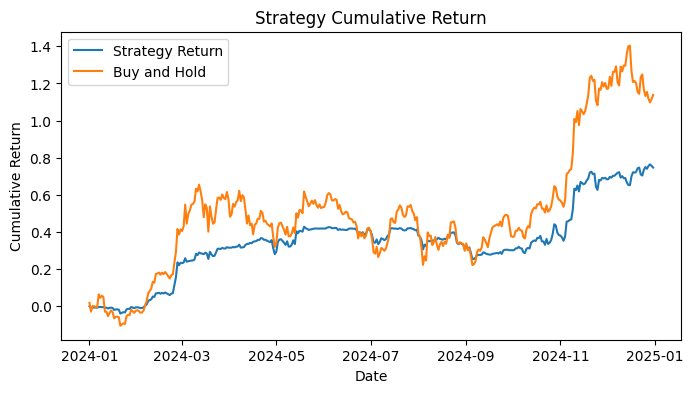

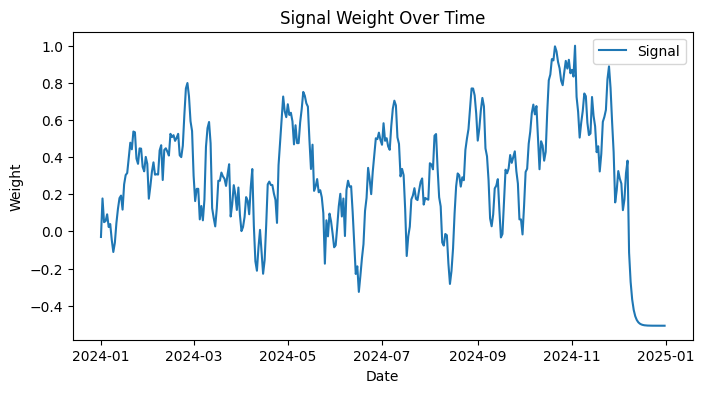

In [26]:
df = df[df.index.year == 2024]

run_backtest(df)

Overall Annual Return: 117.0%
Overall Annual Sharpe Ratio: 2.4338
Maximum Drawdown: -23.81 %
Win/Loss Ratio: 1.19
Alpha: 0.5819
Beta: 0.654

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.170039    0.480747     0.654028      0.581944       2.433796


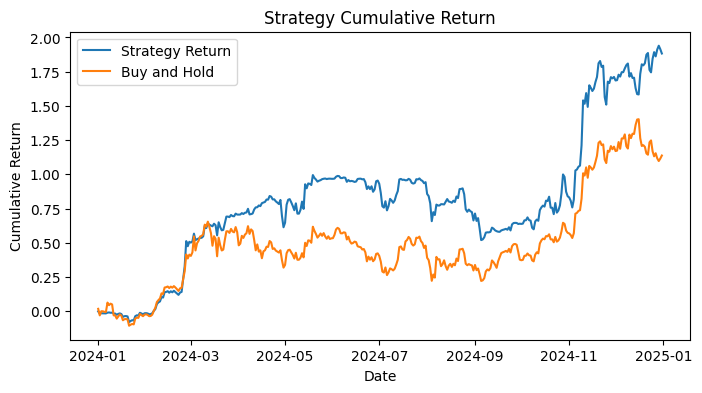

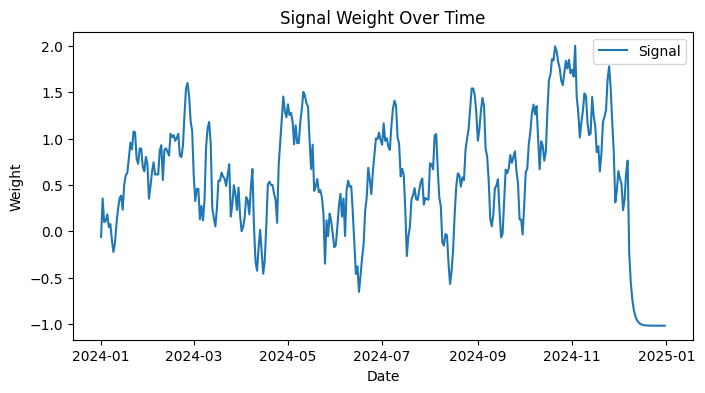

In [27]:
df['signal'] = df['signal'] * 2
run_backtest(df)

Overall Annual Return: 89.92%
Overall Annual Sharpe Ratio: 1.6843
Maximum Drawdown: -26.18 %
Win/Loss Ratio: 1.09
Alpha: 0.0
Beta: 1.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024        0.89919    0.533875          1.0           0.0        1.68427


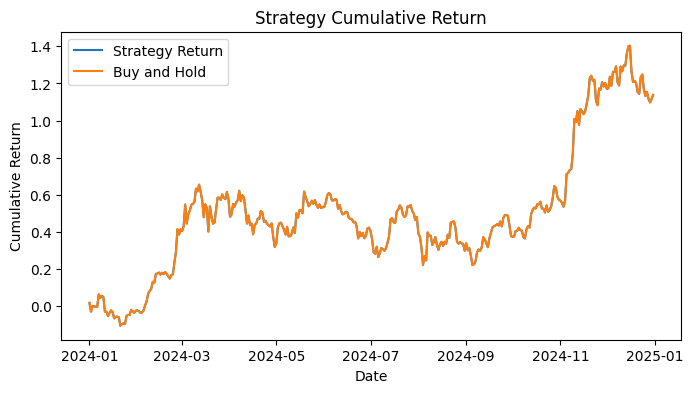

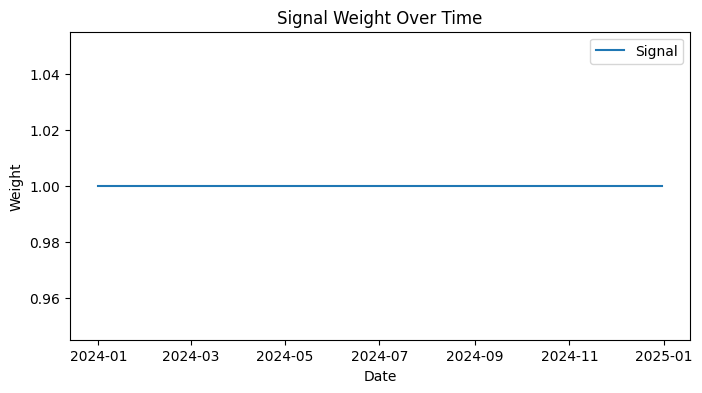

In [28]:
df['signal'] = 1

run_backtest(df)